In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/SoundClassification/vit_cnn

/content/drive/MyDrive/SoundClassification/vit_cnn


In [3]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 5.0 MB/s 


# Libraries

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torchvision.transforms as T
from class_balanced_loss import CB_loss
from torchaudio.transforms import TimeMasking, FrequencyMasking

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score

import random
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sn 
import warnings

#from Loader import LungSoundDS # WITH MIXUP
from SoundLoader import LungSoundDS
from model import DeiTCnn

random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Loading Data

## Transformations

In [5]:
transformsAug = T.Compose([T.Resize((224,224)),
                        T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                        FrequencyMasking(freq_mask_param=50), 
                        TimeMasking(time_mask_param=50)])

In [6]:
transforms = T.Compose([T.Resize((224,224)),
                        T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                        ])

## Train Dataset

In [ ]:
train_path = r'train'
train_df = pd.read_csv('train.csv')
print('Number of samples:',len(train_df))

Number of samples: 4142


## Splitting Dataset

In [ ]:
targets = train_df['id'].values
index = np.arange(len(targets))
classes_names = ['Normal','Crackles','Wheezes','W_C']

In [ ]:
# Split Into 90% for training and 10% for test
train_idx, val_idx = train_test_split(index,test_size=0.5, shuffle=True, stratify=targets, random_state=42)

In [ ]:
train_idx, val_idx = train_test_split(index[train_idx],test_size=0.5, shuffle=True, stratify=targets[train_idx], random_state=42)

In [ ]:
# train dataset
train_samples = train_df.iloc[train_idx]
train_dataset = LungSoundDS(train_samples, train_path, transform=transforms)

In [ ]:
# validation dataset
val_samples = train_df.iloc[train_idx]
val_dataset = LungSoundDS(val_samples, train_path, transform=transforms)

In [ ]:
_, samples_per_cls = np.unique(train_df.id, return_counts=True)

## Test Dataset

In [ ]:
test_path = r'test'
test_df = pd.read_csv('test.csv')
                 
test_dataset = LungSoundDS(test_df, test_path, transform=transforms)
print('Number of samples:',len(test_dataset))

Number of samples: 2756


# Functions 

In [ ]:
# Mixup data
def mixup_data(x, y, alpha=2.0, device=device):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    
    lam = np.random.beta(alpha, alpha)

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    
    mixed_x = lam*x + (1 - lam)*x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam*criterion(pred, y_a) + (1 - lam)*criterion(pred, y_b)

In [ ]:
# Calculate accuracy for each batch
def model_acc(output, target):
    _, y_pred = torch.max(output, dim = 1)  
    correct = torch.eq(y_pred, target).float()
    
    acc = correct.sum().item()/len(correct)
    return acc

In [ ]:
# Train the Model
def train(model, device, criterion, dataLoader, optimizer, mixup=False):
    model.train()
    batch_loss=0
    batch_acc=0
    
    for data, target in dataLoader:
        data, target = data.to(device), target.to(device)
        # applying mixup 
        if mixup:
          mixed_data, target_a, target_b, lam = mixup_data(data, target, alpha=2.0, device=device)
          # optimizer
          optimizer.zero_grad()
          output = model(mixed_data)
          loss = mixup_criterion(criterion, output, target_a, target_b, lam)
        else:
          optimizer.zero_grad()
          output = model(data)
          loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # Add all batch loss
        batch_loss += loss.item()*data.size(0)
        
        acc = model_acc(output, target)
    
        # Add all batch accuracy
        batch_acc += acc*target.size(0)

    # Epoch Loss and Accuracy 
    train_loss = batch_loss/len(dataLoader.dataset)
    train_acc  = batch_acc/len(dataLoader.dataset)
    
    return train_loss, train_acc

In [ ]:
# Generate Dataloader to Feed the Model
batch_size = 32

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
validloader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [ ]:
# evaluate metrics 
def compute_metrics(model, device, criterion, dataLoader):
    with torch.no_grad():
        model.eval()

        val_loss = 0
        val_correct = 0

        score_list   = []
        pred_list    = []
        target_list  = []
        
        for data, target in dataLoader:   
            image, target = data.to(device), target.to(device)

            output = model(image)

            # Compute Loss
            loss = criterion(output, target)
            val_loss += loss.item()*data.size(0)

            # Calculate the number of correctly classified examples
            pred = output.argmax(dim=1)
            val_correct += pred.eq(target).sum().item()

            # Storing 
            if len(pred)==1:
                pred_list.append(pred.squeeze().tolist())
                target_list.append(target.squeeze().tolist())
            else:    
                pred_list.extend(pred.squeeze().tolist())
                target_list.extend(target.squeeze().tolist())
            score_list.extend(nn.Softmax(dim = 1)(output).tolist())
            
    # metrics
    F1_score = f1_score(target_list, pred_list, average="macro") 
    Accuracy = accuracy_score(target_list, pred_list) 
    Roc_AUC  = roc_auc_score(target_list, score_list, average="macro",multi_class='ovo')
    cnf_matrix= confusion_matrix(target_list, pred_list)

    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    Score = (TPR.mean()+TNR.mean())/2
    
    # put values into dictionary
    metrics_dict = {"Accuracy": Accuracy,
                    "F1-score": F1_score,
                    "Roc_AUC":Roc_AUC,
                    "Loss": val_loss/len(dataLoader.dataset),
                    "CM":cnf_matrix,
                    "Target":target_list,
                    "Predict":pred_list,
                    "Sensitivity":TPR.mean(),
                    "Specificity":TNR.mean(),
                    "Score": Score}
    
    return metrics_dict

# Model

In [ ]:
num_classes = len(np.unique(targets))

In [12]:
#model = ViTCnn(num_classes=num_classes,pretrained=True,freeze=True)
model = DeiTCnn(num_classes=num_classes, pretrained=True, model="base", freeze=False, attention=True)
model.to(device);

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


## Model Summary

In [ ]:
from torchsummary import summary
summary(model, (3,224,224))

## Model Hyperparams

In [ ]:
# filter(lambda p: p.requires_grad, model.parameters()), 
beta=0.99
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(),lr=learning_rate,weight_decay=0)
criterion = CB_loss(device, samples_per_cls=samples_per_cls, no_of_classes=num_classes, beta=beta)

# Training Model

In [ ]:
# creating dictionary for statistics

## Train Set Dictionary 
train_stats = {"acc": [], "loss": []}
val_stats = {"acc": [], "loss": []}

In [ ]:
## Dictionary for epoch Statistics

epoch_train = {"acc": [], "loss": []}
epoch_val = {"acc": [], "loss": []}
best_val_score = 0
epochs = 100

# Epoch Loop for Training and Evaluation
for epoch in range(epochs):
    train_loss, train_acc = train(model, device, criterion, trainloader, optimizer, mixup=True)

    metrics = compute_metrics(model, device, criterion, validloader)

    # Statistics
    train_stats["acc"].append(train_acc)
    train_stats["loss"].append(train_loss)

    val_stats["acc"].append(metrics["Accuracy"])
    val_stats["loss"].append(metrics["Loss"])

    # Saving best Model
    if metrics["Score"]>best_val_score:
        torch.save(model.state_dict(), "best_model)
        best_val_score = metrics['Score']
        
    # Print Metris
    print(f'Epoch {epoch+1} --> Train Metrics: Accuracy: {train_acc:.2f} -- Loss: {train_loss:.2f} | Validation Metrics: Accuracy: {metrics["Accuracy"]:.2f} -- Score: {metrics["Score"]:.2f} -- Loss: {metrics["Loss"]:.2f}')

print('finish training')

# Statistics

In [ ]:
# Loss Figure plotting and saving figure
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5)) 
plt.grid() 
plt.plot(train_stats['loss'])
plt.plot(val_stats['loss'])
plt.legend(['Training','Validation'])
plt.ylabel('Loss'), plt.xlabel('Epochs');
plt.savefig('loss_curve.pdf', dpi=200), plt.show();

In [ ]:
# Accuracy plotting and saving figure
plt.figure(figsize=(8,5)) 
plt.grid() 
plt.plot(train_stats['acc'])
plt.plot(val_stats['acc'])
plt.legend(['Training','Validation'])
plt.ylabel('Accuracy'), plt.xlabel('Epochs');
plt.savefig('acc_curve.pdf',dpi=200), plt.show();

# Evaluation

In [ ]:
#loading 
model = DeiTCnn(num_classes=num_classes, pretrained=True, model="base", freeze=False, attention=True)
model.load_state_dict(torch.load('deit3_cnn.zip', map_location=device)); 
model.to(device);

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


In [ ]:
test_metrics = compute_metrics(model, device, criterion, testloader)

## Confusion Matrix

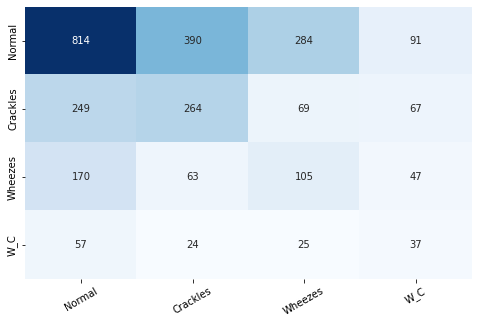

In [ ]:
plt.figure(figsize = (8,5))
ax = sn.heatmap(test_metrics['CM'], annot=True, fmt=".0f", cmap ='Blues',xticklabels=classes_names, yticklabels=classes_names,
           linecolor='k',cbar=False)
ax.set_xticklabels(classes_names,rotation=30);
#plt.savefig("cm.pdf", dpi=200), plt.show();

# Performance

In [ ]:
print('Results for Test Set \n')
print(f"Accuracy: {test_metrics['Accuracy']:.4f}")
print(f"Roc AUC: {test_metrics['Roc_AUC']:.4f}")
# Sensitivity
print(f"Sensitivity : {test_metrics['Sensitivity']:.4f}")
# Specificity
print(f"Specificity : {test_metrics['Specificity']:.4f}")
# Score
print(f"Score : {test_metrics['Score']:.4f}")

Results for Test Set 

Accuracy: 0.4427
Roc AUC: 0.6176
Sensitivity : 0.3634
Specificity : 0.7828
Score : 0.5731
